In [ ]:
# Mounting Google Drive on Colab for working with the dataset
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# Importing relevant libraries
import os
import cv2
import platform
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output
import keras
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Add, add
from tensorflow.keras.layers import InputLayer, Input, Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, Activation, MaxPool2D, ZeroPadding2D, SeparableConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model, Sequential
from keras import regularizers
os.environ['PYTHONHASHSEED'] = '73'

# Setting seed as 73
seed = 73
random.seed(seed)
np.random.seed(seed)

print(platform.platform())
%matplotlib inline

Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic


In [ ]:
# importing tqdm
from tqdm import tqdm

# train and test dataset directories (as per google drive)
train_image_dir ='/content/drive/MyDrive/google net implementation/dataset/Unzipped/fire_dataset/train'
test_image_dir = '/content/drive/MyDrive/google net implementation/dataset/Unzipped/fire_dataset/test'

img_map = []

def prepareData(Dir, strat):
    cats = ["fire_images","non_fire_images"]
    for category in cats:
        path = os.path.join(Dir,category)
        class_num = cats.index(category)
        
        for img in tqdm(os.listdir(path)):
            img_path = os.path.join(path,img)
            img_map.append({'path': img_path, 'label': category})

prepareData(train_image_dir,'train')
prepareData(test_image_dir,'test')

img_map = pd.DataFrame(img_map).sample(frac=1,random_state=seed)

100%|██████████| 49/49 [00:00<00:00, 225105.03it/s]


In [ ]:
img_map

,path,label
291,/content/drive/MyDrive/google net implementati...,fire_images
107,/content/drive/MyDrive/google net implementati...,fire_images
787,/content/drive/MyDrive/google net implementati...,non_fire_images
427,/content/drive/MyDrive/google net implementati...,fire_images
304,/content/drive/MyDrive/google net implementati...,fire_images
...,...,...
784,/content/drive/MyDrive/google net implementati...,non_fire_images
394,/content/drive/MyDrive/google net implementati...,fire_images
942,/content/drive/MyDrive/google net implementati...,fire_images
146,/content/drive/MyDrive/google net implementati...,fire_images


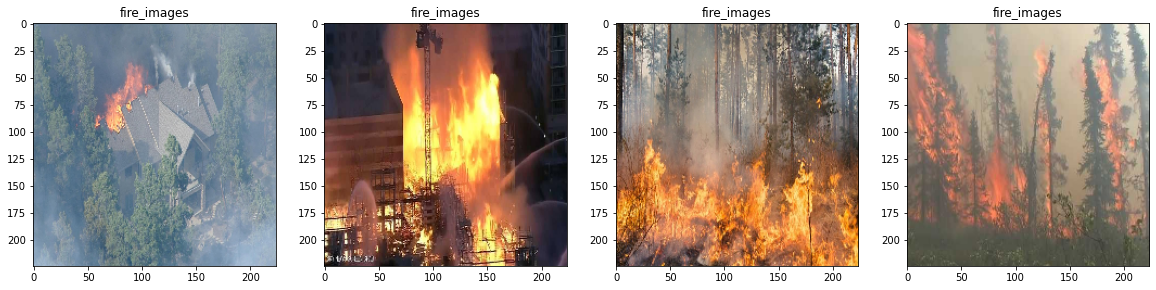

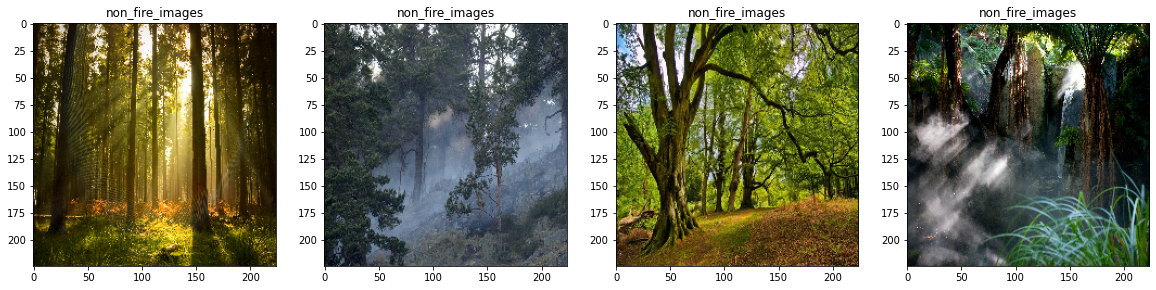

In [ ]:
import matplotlib.pyplot as plt

# printing images along with the ground truth labels for visualization
def print_images(samples): 
    images = samples["path"].to_numpy()
    labels = samples['label'].to_numpy()
    
    fig=plt.figure(figsize=(20, 8))
    columns = 4
    rows = 1
    
    for i, image_path in enumerate(images):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        fig.add_subplot(rows,columns,i + 1)
        title = '{}'.format(labels[i])
        
        Sample_image = cv2.resize(image, (224, 224), interpolation = cv2.INTER_CUBIC)
        
        plt.imshow(Sample_image, cmap='gray')
        plt.title(title)
        
    plt.show()
        
print_images(img_map[img_map['label']=="fire_images"].iloc[0:4])
print_images(img_map[img_map['label']=="non_fire_images"].iloc[0:4])

%matplotlib inline

In [ ]:
# printing the label count (fire or not fire) in the dataset
def getLabelCount(frame):
    label_count = pd.Series(frame['label'].values.ravel()).value_counts()
    n_classes = (label_count)
    return label_count

label_count = getLabelCount(img_map)
print(label_count)

fire_images        755
non_fire_images    244
dtype: int64


In [ ]:
# Shuffling the dataset and splitting it into train, val and test
from sklearn.model_selection import StratifiedShuffleSplit

features = img_map['path'].to_numpy()
labels = img_map['label'].to_numpy()

stratified_sample = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=73)

In [ ]:
for train_index, test_index in stratified_sample.split(features, labels):
    X_train, test_X = features[train_index], features[test_index]
    y_train, test_y = labels[train_index], labels[test_index]
    
half_size = np.int(len(test_X) / 2)
X_test, y_test = test_X[0:half_size], test_y[0:half_size]
X_val, y_val = test_X[half_size:], test_y[half_size:]

In [ ]:
train_map = pd.DataFrame()
train_map['path'], train_map['label'] = X_train, y_train

val_map = pd.DataFrame()
val_map['path'], val_map['label'] = X_val, y_val

test_map = pd.DataFrame()
test_map['path'], test_map['label'] = X_test, y_test

In [ ]:
# data summary
print('> {} train size'.format(X_train.shape[0]))
print('> {} test size'.format(X_test.shape[0]))
print('> {} val size'.format(X_val.shape[0]))

> 799 train size
> 100 test size
> 100 val size


In [ ]:
import cv2
import time
import imageio
import imgaug.augmenters as iaa
import imgaug as ia
ia.seed(73)

ColorCh = 3
IMG_SIZE = 224
input_shape=(IMG_SIZE, IMG_SIZE, ColorCh)

# printing th two categories of images (fire and not fire)
classes = ('fire_images','non_fire_images')
CATEGORIES = sorted(classes)

print('> Classes:',CATEGORIES)

> Classes: ['fire_images', 'non_fire_images']


In [ ]:
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

datagen = ImageDataGenerator(rescale = 1./255, 
                             horizontal_flip=True,
                             brightness_range=[1.0,1.3],
                             rotation_range=15,
                             #zoom_range=0.2
                            )

In [ ]:
batch_size = 64

# get_generator function to generate a data loader accordinf to the batch size and dataset 
def get_generator(frame_):
    generator = datagen.flow_from_dataframe(
                          dataframe=frame_,
                          x_col="path",
                          y_col="label",
                          batch_size=batch_size,
                          seed=seed,
                          shuffle=False,
                          class_mode="sparse",
                          color_mode="rgb",
                          save_format="jpeg",
                          target_size=(IMG_SIZE,IMG_SIZE)             
             )
    
    return generator

In [ ]:
# generating train dataloader
train_df = train_map.sample(frac=1, random_state=seed)
train_generator = get_generator(train_df)

print('> label count for train set')
getLabelCount(train_df)

Found 799 validated image filenames belonging to 2 classes.
> label count for train set


fire_images        604
non_fire_images    195
dtype: int64

In [ ]:
# geenerating test dataloader
test_df = test_map.sample(frac=1, random_state=seed)
test_generator = get_generator(test_df)

print('> label count for test set')
getLabelCount(test_df)

Found 100 validated image filenames belonging to 2 classes.
> label count for test set


fire_images        70
non_fire_images    30
dtype: int64

In [ ]:
# generating val dataloader
val_df = val_map.sample(frac=1, random_state=seed)
val_generator = get_generator(val_df)

print('> label count for val set')
getLabelCount(val_df)

Found 100 validated image filenames belonging to 2 classes.
> label count for val set


fire_images        81
non_fire_images    19
dtype: int64

In [ ]:
print('> input shape:', input_shape)

> input shape: (224, 224, 3)


In [ ]:
kernel_regularizer = regularizers.l2(0.0001)

final_activation = 'sigmoid'
entropy = 'sparse_categorical_crossentropy'

In [ ]:
ColorCh = 3
IMG_SIZE = 224
input_shape=(IMG_SIZE, IMG_SIZE, ColorCh)
n_classes = 2

Inception Module: Naive version

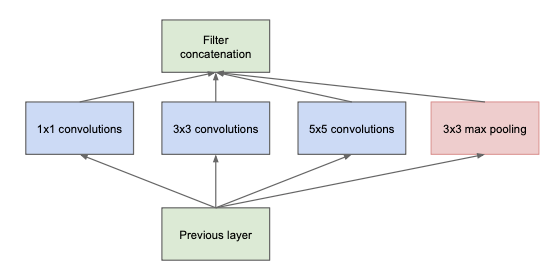

Inception Module: Dimension Reductions

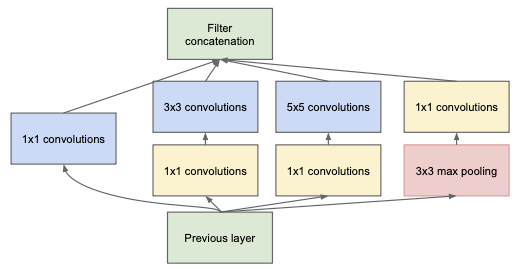

In [ ]:
# defining fully connected layers present in the network
def FCLayers(baseModel):
    baseModel.trainable = True
    headModel = baseModel.output
    headModel = Dropout(0.5, seed=73)(headModel)
    headModel = Dense(n_classes, activation=final_activation)(headModel)
    model = Model(inputs = baseModel.input, outputs = headModel)
    5
    return model

In [ ]:
from keras.layers.merge import concatenate

# Implementation of Inception Module as per the research paper 
def Inception_block(input_layer, f1, f2, f3, f4):    
    
    path1 = Conv2D(filters=f1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
    
    path2 = Conv2D(filters = f2[0], kernel_size = (1,1), 
                   padding = 'same', activation = 'relu')(input_layer)
    
    path2 = Conv2D(filters = f2[1], kernel_size = (3,3), 
                   padding = 'same', activation = 'relu')(path2)

    path3 = Conv2D(filters = f3[0], kernel_size = (1,1), 
                   padding = 'same', activation = 'relu')(input_layer)
    
    path3 = Conv2D(filters = f3[1], kernel_size = (5,5), 
                   padding = 'same', activation = 'relu')(path3)

    path4 = MaxPooling2D((3,3), strides= (1,1), 
                         padding = 'same')(input_layer)
    
    path4 = Conv2D(filters = f4, kernel_size = (1,1), 
                   padding = 'same', activation = 'relu')(path4)
    
    output_layer = concatenate([path1, path2, path3, path4], axis = -1)

    return output_layer

In [ ]:
# auxiliary_classifiers
def Extra_network_2(X):
    X2 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
    X2 = Conv2D(filters = 128, kernel_size = (1,1), 
                padding = 'same', activation = 'relu')(X2)
    
    X2 = Flatten()(X2)
    X2 = Dense(1024, activation = 'relu')(X2)
    X2 = Dropout(0.5)(X2)
    X2 = Dense(n_classes,name="output2")(X2)
    return X2


def Extra_network_1(X):
    X1 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
    X1 = Conv2D(filters = 128, kernel_size = (1,1), 
                padding = 'same', activation = 'relu')(X1)
    
    X1 = Flatten()(X1)
    X1 = Dense(1024, activation = 'relu')(X1)
    X1 = Dropout(0.5)(X1)
    X1 = Dense(n_classes,name="output1")(X1)
    return X1

In [ ]:
# functions for defining various layers using inception block present in the network
def layer_4(X):
    X = Inception_block(X, 192, (96, 208) , (16, 48), 64)
    
    X1 = Extra_network_1(X)
    
    X = Inception_block(X, 160, (112, 224), (24, 64), 64)
    X = Inception_block(X, 128, (128, 256), (24, 64), 64)
    X = Inception_block(X, 112, (144, 288), (32, 64), 64)
    
    X2 = Extra_network_2(X)
    
    X = Inception_block(X, 256, (160, 320), (32, 128), 128)
    X = MaxPooling2D(pool_size = 3, strides = 2)(X)
    
    return X, X1, X2

def layer_3(X):
    X = Inception_block(X, 64, (96, 128), (16, 32), 32)
    X = Inception_block(X, 128, (128, 192), (32, 96), 64)
    X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)
    
    return X

def layer_2(X):
    X = Conv2D(filters = 64, 
               kernel_size = 1, 
               strides = 1, 
               padding = 'same', 
               activation = 'relu')(X)
    
    X = Conv2D(filters = 192, 
               kernel_size = 3, 
               padding = 'same', 
               activation = 'relu')(X)
    
    X = MaxPooling2D(pool_size= 3, strides = 2)(X)
    
    return X

GoogleNet incarnation of the Inception Architecture


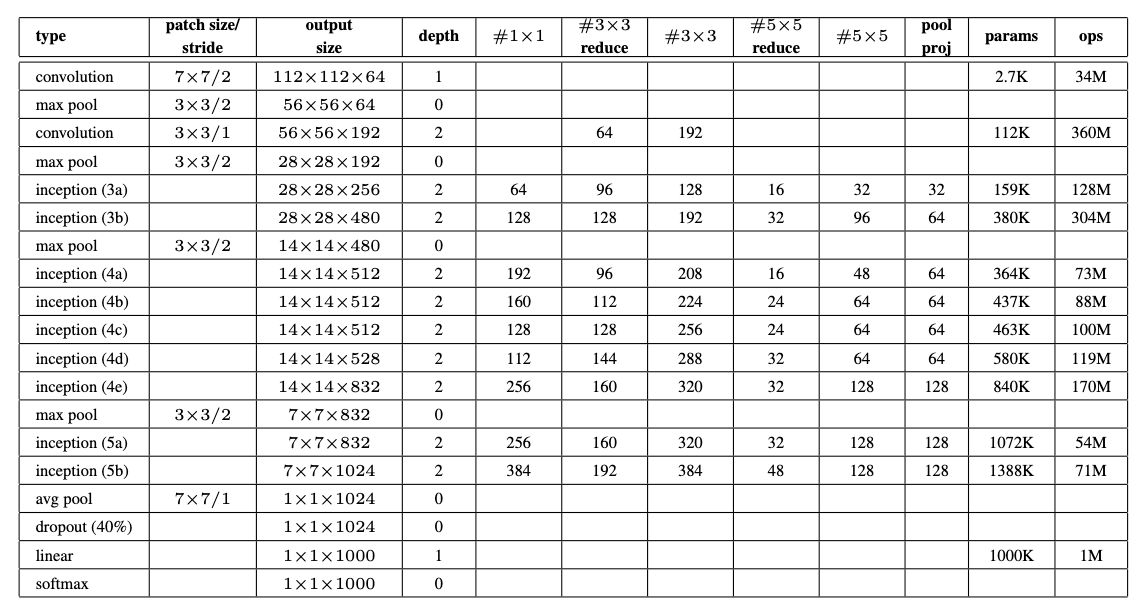

## About the Architecure
* All the convolutions, including those inside the Inception modules, use 
rectified linear activation.
* The size of the receptive field in our network is 224×224 taking RGB color channels with mean sub- traction. “#3×3 reduce” and “#5×5 reduce” stands for the number of 1×1 filters in the reduction layer used before the 3×3 and 5×5 convolutions.
* One can see the number of 1×1 filters in the pro- jection layer after the built-in max-pooling in the pool proj column. All these reduction/projection layers use rectified linear activation as well.
* The network is 22 layers deep when counting only layers with parameters (or 27 layers if we also count pooling). The overall number of layers (independent build- ing blocks) used for the construction of the network is about 100.


#### The exact structure of the extra network on the side, including the auxiliary classifier, is as follows:
* An average pooling layer with 5×5 filter size and stride 3, resulting in an 4×4×512 output
for the (4a), and 4×4×528 for the (4d) stage.
* A 1×1 convolution with 128 filters for dimension reduction and rectified linear activation.
* A fully connected layer with 1024 units and rectified linear activation.
* A dropout layer with 70% ratio of dropped outputs.
* A linear layer with softmax loss as the classifier (predicting the same 1000 classes as the main classifier, but removed at inference time).

GoogleNet Architecture

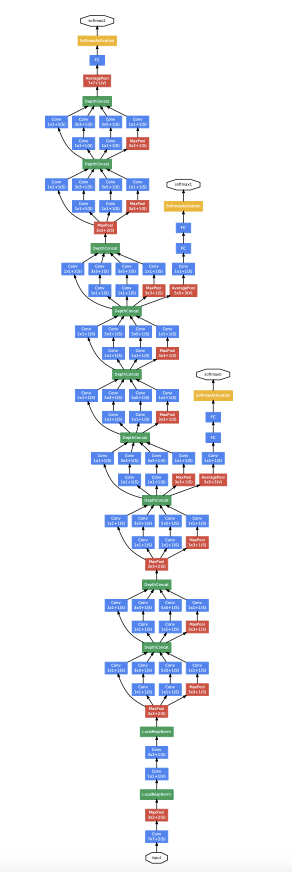

In [ ]:
# final function returning the GoogleNet using above utlity function to create the network 
def load_GoogLeNet():
    input_layer = Input(shape = input_shape)
    
    X = Conv2D(64, kernel_size = 7, strides = 2, 
               padding = 'valid', activation = 'relu')(input_layer)
    
    X = MaxPooling2D(pool_size = 3, strides = 2)(X)
    
    X = layer_2(X)
    X = layer_3(X)
    X, X1, X2 = layer_4(X)

    X = Inception_block(X, 256, (160, 320), (32, 128), 128)
    X = Inception_block(X, 384, (192, 384), (48, 128), 128)

    X = GlobalAveragePooling2D()(X)
    X = Dropout(0.6)(X)
    
    X = Dense(n_classes,name="output3")(X)
  
    model = Model(input_layer, [X, X1, X2], name = 'GoogLeNet')

    return model

load_GoogLeNet().summary()

Model: "GoogLeNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 109, 109, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 54, 54, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 54, 54, 64)   4160        max_pooling2d[0][0]              
__________________________________________________________________________________________

In [ ]:
def getMetrics(name, type_):
    if name == 'GoogLeNet':
        if type_ == 'accuracy':
            return 'output3_accuracy'
        if type_ == 'loss':
            return 'output3_loss'
        if type_ == 'val_accuracy':
            return 'val_output3_accuracy'
        if type_ == 'val_loss':
            return 'val_output3_loss'
        
    else:
        if type_ == 'accuracy':
            return 'accuracy'
        if type_ == 'loss':
            return 'loss'
        if type_ == 'val_accuracy':
            return 'val_accuracy'
        if type_ == 'val_loss':
            return 'val_loss'

In [ ]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau

# setting the various hyperparameters for training  
EPOCHS = 20
patience = 3

start_lr = 0.0001
min_lr = 0.0001
max_lr = 0.0005

rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8
        
def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr
        
def getCallbacks(name):
    class myCallback(Callback):
        def on_epoch_end(self, epoch, logs={}):
            if ((logs.get(getMetrics(name,'accuracy'))>=0.999)):
                print("\nLimits Reached cancelling training!")
                self.model.stop_training = True

            
    end_callback = myCallback()

    lr_plat = ReduceLROnPlateau(patience = 2, mode = 'min')

    lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=False)



    checkpoint_filepath = '/content/drive/MyDrive/google net implementation/GoogLeNet_Weights.h5'

    model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                        save_weights_only=True,
                                        monitor=getMetrics(name, 'val_loss'),
                                        mode='min',
                                        verbose = 1,
                                        save_best_only=True)

    import datetime
    log_dir="logs/fit/" + '_' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")  
    tensorboard_callback = TensorBoard(log_dir = log_dir, write_graph=True, histogram_freq=1)

    return [end_callback, 
             lr_callback, 
             model_checkpoints,
             #tensorboard_callback,
             lr_plat
            ]

GoogLeNet_callbacks = getCallbacks('GoogLeNet')

In [ ]:
def CompileModel(name, model):
    if name == 'GoogLeNet':
        model.compile(optimizer='adam', loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), metrics={"output1":"accuracy", "output2":"accuracy", "output3":"accuracy"})
    else:
        model.compile(optimizer='adam', loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])
    return model

# funtion for fitting the GoogleNet model, according to the created model and hyperparameters
def FitModel(model, name):
    callbacks_ = GoogLeNet_callbacks
    if name == 'GoogLeNet':
        callbacks_ = GoogLeNet_callbacks
    history = model.fit(train_generator, 
                        epochs=EPOCHS,
                        callbacks=callbacks_,
                        validation_data = val_generator,
                        steps_per_epoch=(len(train_generator.labels) / 80),
                        validation_steps=(len(val_generator.labels) / 80),
                       )
    
    model.load_weights('/content/drive/MyDrive/google net implementation/GoogLeNet_Weights.h5')

    final_accuracy_avg = np.mean(history.history[getMetrics(name, "val_accuracy")][-5:])

    final_loss = history.history[getMetrics(name, "val_loss")][-1]
  
    group = {history: 'history', name: 'name', model: 'model', final_accuracy_avg:'acc', final_loss: 'loss'}

    print('\n')
    print('---'*15)
    print(name,' Model')
    print('Total Epochs :', len(history.history[getMetrics(name, 'loss')]))    
    print('Restoring best Weights')
    
    index = (len(history.history[getMetrics(name, 'loss')]) - (patience + 1))
    print('---'*15)
    print('Best Epoch :', index)
    print('---'*15)
    
    train_accuracy = history.history[getMetrics(name, 'accuracy')][index]
    train_loss = history.history[getMetrics(name, 'loss')][index]
    
    val_accuracy = history.history[getMetrics(name, 'val_accuracy')][index]
    val_loss = history.history[getMetrics(name, 'val_loss')][index]

    print('Accuracy on train:', train_accuracy,
          '\tLoss on train:', train_loss)
    
    print('Accuracy on val:', val_accuracy ,
          '\tLoss on val:', val_loss)
    print('---'*15)

    return model, history

In [ ]:
def BuildModel(name):
    if name == 'GoogLeNet':
        prepared_model = load_GoogLeNet()
        
    compiled_model = CompileModel(name, prepared_model)
    return compiled_model

## results for the image dataset


In [ ]:
# compiling the model and fitting it
g_compiled_model = BuildModel('GoogLeNet')
g_model, g_history = FitModel(g_compiled_model, 'GoogLeNet')

Epoch 1/20
9/9 [==============================] - 55s 4s/step - loss: 1.9200 - output3_loss: 0.6456 - output1_loss: 0.6308 - output2_loss: 0.6436 - output3_accuracy: 0.7051 - output1_accuracy: 0.7199 - output2_accuracy: 0.7216 - val_loss: 1.4402 - val_output3_loss: 0.4802 - val_output1_loss: 0.4816 - val_output2_loss: 0.4784 - val_output3_accuracy: 0.8100 - val_output1_accuracy: 0.8100 - val_output2_accuracy: 0.8100

Epoch 00001: val_output3_loss improved from inf to 0.48023, saving model to /content/drive/MyDrive/google net implementation/GoogLeNet_Weights.h5
Epoch 2/20
9/9 [==============================] - 35s 4s/step - loss: 1.4185 - output3_loss: 0.4739 - output1_loss: 0.4802 - output2_loss: 0.4643 - output3_accuracy: 0.7512 - output1_accuracy: 0.7512 - output2_accuracy: 0.7512 - val_loss: 0.8806 - val_output3_loss: 0.2753 - val_output1_loss: 0.3264 - val_output2_loss: 0.2790 - val_output3_accuracy: 0.8100 - val_output1_accuracy: 0.8100 - val_output2_accuracy: 0.8100

Epoch 00002:

In [ ]:
%matplotlib inline
def print_graph(item, index, history):
    plt.figure()
    train_values = history.history[item][0:index]
    plt.plot(train_values)
    test_values = history.history['val_' + item][0:index]
    plt.plot(test_values)
    plt.legend(['training','validation'])
    plt.title('Training and validation '+ item)
    plt.xlabel('epoch')
    plt.show()
    plot = '{}.png'.format(item)
    plt.savefig(plot)

In [ ]:
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve, accuracy_score, classification_report, confusion_matrix

def test_set_results(pred_value, n=1):    
    y_test = test_generator.labels
    X_test, _ = test_generator.next()
    
    corr_pred = metrics.confusion_matrix(y_test, pred_value)
    fig=plt.figure(figsize=(10, 8))
    ax = plt.axes()
    
    sns.heatmap(corr_pred,annot=True, fmt="d",cmap="Purples", xticklabels=CATEGORIES, yticklabels=CATEGORIES)
    ax.set_title('Dense Output {}'.format(n))
    plt.show()
    
    n_correct = np.int(corr_pred[0][0] + corr_pred[1][1])
    print('...'*15)

    print('> Correct Predictions:', n_correct)
    
    n_wrongs = len(y_test) - n_correct
    print('> Wrong Predictions:', n_wrongs)
    print('...'*15)
    
    print(classification_report(test_generator.labels, pred_value, target_names=CATEGORIES))

In [ ]:
def printResults(name, model):
    predictions = model.predict(test_generator, verbose=1)
    preds = np.argmax(predictions, axis=1)
    test_set_results(preds)

In [ ]:
# utility function for printing the training results and final accuracies and loss
def model_summary(model, history, name):
    index = (len(history.history[getMetrics(name, 'loss')]) - (patience + 1))
    print('Best Epochs: ', index)
    
    if name == 'GoogLeNet':
        results = model.evaluate(test_generator, verbose=1)
        loss, output3_loss, output1_loss, output2_loss, output3_accuracy, output1_accuracy, output2_accuracy = results
        
        for i in range(3):
            n = i + 1
            out_layer = 'Output Layer {}'.format(n)
            
            if n == 1:
                test_accuracy = output1_accuracy
                test_loss = output1_loss

            if n == 2:
                test_accuracy = output2_accuracy
                test_loss = output2_loss
                
            if n == 3:
                test_accuracy = output3_accuracy
                test_loss = output3_loss
                
                
            output_name = 'output{}_'.format(n)
            train_accuracy, train_loss = history.history[output_name + 'accuracy'][index], history.history[output_name + 'loss'][index]
            
  
            print_graph(output_name + 'loss', index, history)
            print_graph(output_name + 'accuracy', index, history)
        
            print('---'*15)  
            print('GoogLeNet Dense output {}:'.format(n))
            
            print('> Accuracy on train :'.format(out_layer), train_accuracy, 
                  '\tLoss on train:',train_loss)
        
            print('> Accuracy on test :'.format(out_layer), test_accuracy,
                  '\tLoss on test:',test_loss)
            
            print('---'*15)
            print('> predicting test')
            print('---'*15)
            
            predictions = model.predict(test_generator, verbose=1)
            preds = np.argmax(predictions[i], axis=1)
            test_set_results(preds, n)
                
    else:
        test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
        
        train_accuracy = history.history['accuracy'][index]
        train_loss = history.history['loss'][index]

        print_graph('loss', index, history)
        print_graph('accuracy', index, history)
        
        print('---'*15) 
        print(name)
        print('> Accuracy on train:',train_accuracy, 
              '\tLoss on train:',train_loss)
        
        print('> Accuracy on test:',test_accuracy,
              '\tLoss on test:',test_loss)
        
        print('---'*15)
        print('> predicting test')
        print('---'*15)
        
        printResults(name, model)

## results for the video dataset


Best Epochs:  16
2/2 [==============================] - 6s 1s/step - loss: 0.1696 - output3_loss: 0.0468 - output1_loss: 0.0677 - output2_loss: 0.0550 - output3_accuracy: 0.9900 - output1_accuracy: 0.9800 - output2_accuracy: 0.9900


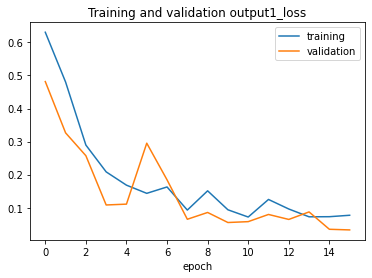

<Figure size 432x288 with 0 Axes>

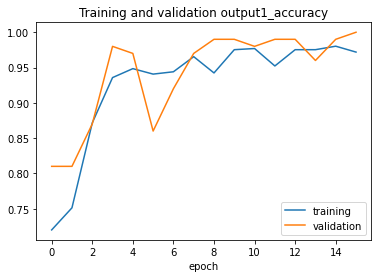

---------------------------------------------
GoogLeNet Dense output 1:
> Accuracy on train : 0.9785832166671753 	Loss on train: 0.06900043785572052
> Accuracy on test : 0.9800000190734863 	Loss on test: 0.06774963438510895
---------------------------------------------
> predicting test
---------------------------------------------
2/2 [==============================] - 6s 1s/step


<Figure size 432x288 with 0 Axes>

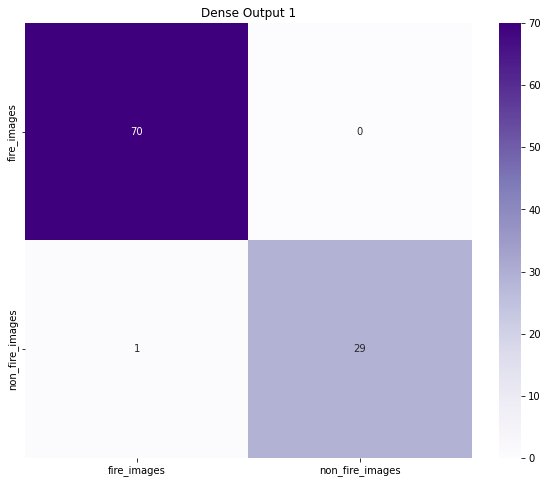

.............................................
> Correct Predictions: 99
> Wrong Predictions: 1
.............................................
                 precision    recall  f1-score   support

    fire_images       0.99      1.00      0.99        70
non_fire_images       1.00      0.97      0.98        30

       accuracy                           0.99       100
      macro avg       0.99      0.98      0.99       100
   weighted avg       0.99      0.99      0.99       100



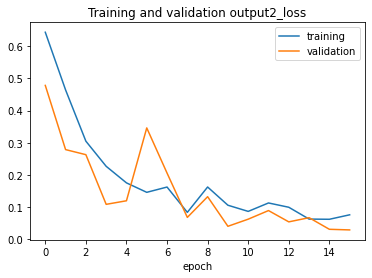

<Figure size 432x288 with 0 Axes>

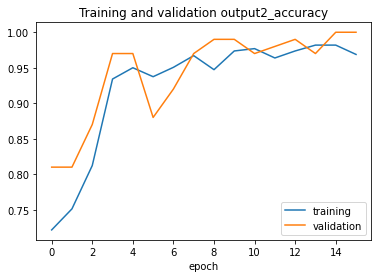

---------------------------------------------
GoogLeNet Dense output 2:
> Accuracy on train : 0.9752883315086365 	Loss on train: 0.06576142460107803
> Accuracy on test : 0.9900000095367432 	Loss on test: 0.055001985281705856
---------------------------------------------
> predicting test
---------------------------------------------
2/2 [==============================] - 6s 1s/step


<Figure size 432x288 with 0 Axes>

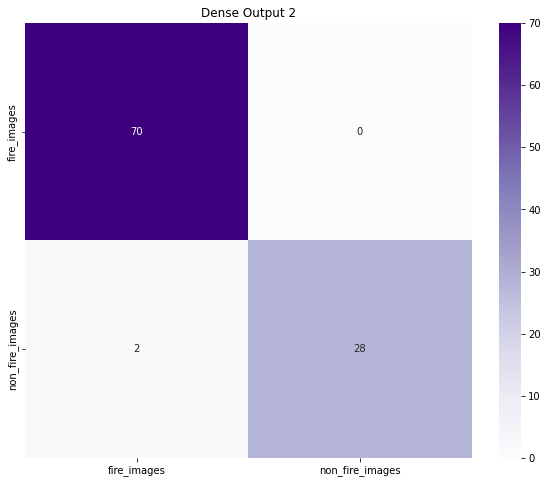

.............................................
> Correct Predictions: 98
> Wrong Predictions: 2
.............................................
                 precision    recall  f1-score   support

    fire_images       0.97      1.00      0.99        70
non_fire_images       1.00      0.93      0.97        30

       accuracy                           0.98       100
      macro avg       0.99      0.97      0.98       100
   weighted avg       0.98      0.98      0.98       100



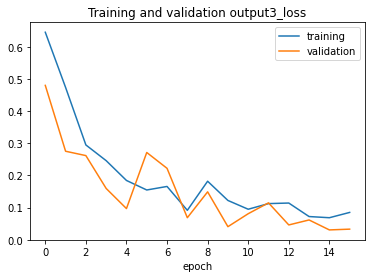

<Figure size 432x288 with 0 Axes>

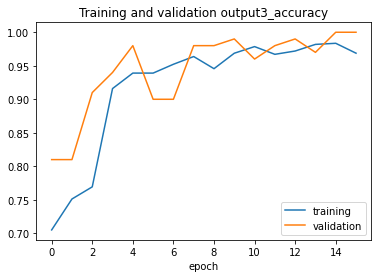

---------------------------------------------
GoogLeNet Dense output 3:
> Accuracy on train : 0.9769357442855835 	Loss on train: 0.06845062971115112
> Accuracy on test : 0.9900000095367432 	Loss on test: 0.04681277647614479
---------------------------------------------
> predicting test
---------------------------------------------
2/2 [==============================] - 5s 1s/step


<Figure size 432x288 with 0 Axes>

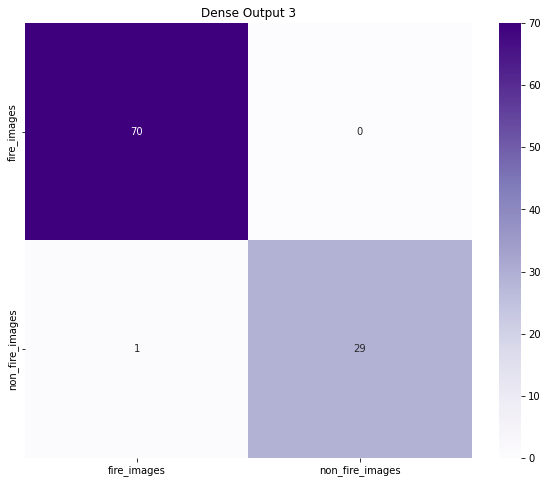

.............................................
> Correct Predictions: 99
> Wrong Predictions: 1
.............................................
                 precision    recall  f1-score   support

    fire_images       0.99      1.00      0.99        70
non_fire_images       1.00      0.97      0.98        30

       accuracy                           0.99       100
      macro avg       0.99      0.98      0.99       100
   weighted avg       0.99      0.99      0.99       100



In [ ]:
# calling the model_sumamry function
model_summary(g_model, g_history, 'GoogLeNet')

### Testing our model on Video Dataset

In [ ]:
from collections import deque
# initialize the image mean for mean subtraction along with the
# predictions queue
mean = np.array([123.68, 116.779, 103.939][::1], dtype="float32")
Q = deque(maxlen=128)

In [ ]:
labels = ['fire','normal']

[INFO] cleaning up...


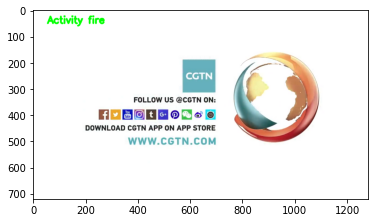

In [ ]:
path = '/content/drive/MyDrive/google net implementation/video1.mp4'
vs = cv2.VideoCapture(path)
writer = None
(W,H) = (None,None)

while True:
  grabbed,frame = vs.read()
  if not grabbed:
    break

  if W is None or H is None:
    (H,W) = frame.shape[:2]


  output = frame.copy()
  frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
  frame = cv2.resize(frame,(224,224)).astype('float32')
  frame = frame/255
  preds = g_model.predict(frame[None,...])
  preds = np.mean(preds,axis=0) # taking mean of the prediction because we get 3 prediction from three output layers so we take mean to get best results

  Q.append(preds)
  results = np.array(Q).mean(axis=0)
  i = np.argmax(results)
  label = labels[i]

  text = " Activity {}".format(label)
  cv2.putText(output, text, (35, 50), cv2.FONT_HERSHEY_SIMPLEX,1.25, (0, 255, 0), 5)

  if writer is None:
    fourcc = cv2.VideoWriter_fourcc(*"MJPG")
    writer = cv2.VideoWriter('/content/final_output.avi', fourcc, 30,(W, H), True) #Once this cell is excuted please check you files section with videos named final_output

  writer.write(output)
  plt.imshow(output)
  key = cv2.waitKey(1) & 0xFF

  if key==ord('q'):
    break

print("[INFO] cleaning up...")
writer.release()
vs.release() # it shows the below frame with the prediction because it was the last frame of the video so whatever will be the last frame it will be displayed 
# Total video with the prediction will be there in your files section of colab 

In [ ]:
# for the prediction run the cell
#labels[i]
# To get more better accuracy do increase the number of epochs